In [7]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
%matplotlib inline

# A. MovieLens 100K Dataset: EDA via Pandas

In [13]:
ML_100k_BASE_URL = 'ml-100k/'

def movielens_url(fname):
    return ML_100k_BASE_URL+fname

## A.1. Read Genres

In [14]:
# names of the columns - see README, u.genre
genre_cols = ['genre', 'genre_id']

genres = pd.read_csv(movielens_url('u.genre'), sep='|', names=genre_cols)

genres

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


## A.2. Read Users

In [15]:
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# Read users from u.user
# user id | age | gender | occupation | zip code
users = pd.read_csv(movielens_url('u.user'), sep='|', names=user_cols)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


## A.3. Read Movies

In [16]:
movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'] + [g for g in genres.sort_values(by='genre_id')['genre']]

# Read movies from u.item
movies = pd.read_csv(movielens_url('u.item'), sep='|', names=movie_cols, encoding='latin-1')

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

In [17]:
# Interesting... find the row with a null release_date!
movies.loc[movies.release_date.isnull()]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Assign movie_id (to check/clean up ratings later)
bad_row_id = 266

# drop the row (in place!)
movies.drop(movies.loc[pd.isnull(movies.release_date)].index, inplace=True)

# Confirm it's gone
movies.loc[movies.release_date.isnull()]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


In [19]:
# Output a table including only the movies with null IMDB urls
movies.loc[movies.IMDb_URL.isnull()]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Output all the fields of the first row
movies.loc[1357]

movie_id                                1358
movie_title           The Deadly Cure (1996)
release_date                     16-Sep-1996
video_release_date                       NaN
IMDb_URL                                 NaN
unknown                                    0
Action                                     1
Adventure                                  0
Animation                                  0
Children's                                 0
Comedy                                     0
Crime                                      0
Documentary                                0
Drama                                      0
Fantasy                                    0
Film-Noir                                  0
Horror                                     0
Musical                                    0
Mystery                                    0
Romance                                    0
Sci-Fi                                     0
Thriller                                   0
War       

In [21]:
# Output all the fields of the second row
movies.loc[1358]

movie_id                               1359
movie_title           Boys in Venice (1996)
release_date                    24-Sep-1996
video_release_date                      NaN
IMDb_URL                                NaN
unknown                                   0
Action                                    0
Adventure                                 0
Animation                                 0
Children's                                0
Comedy                                    0
Crime                                     0
Documentary                               0
Drama                                     1
Fantasy                                   0
Film-Noir                                 0
Horror                                    0
Musical                                   0
Mystery                                   0
Romance                                   0
Sci-Fi                                    0
Thriller                                  0
War                             

This looks like a mistake. The title should've been `Boys`(http://www.imdb.com/title/tt0115742/) instead of `Boys from Venice`. 

In [22]:
# Movies with unknown genre?
movies.loc[movies.unknown==1]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1372,1373,Good Morning (1971),4-Feb-1971,NaN,http://us.imdb.com/M/title-exact?Good%20Mornin...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# There is a field of the movies dataset that has no useful values - what is it?
bad_field = 'video_release_date'
movies.drop(bad_field, 1, inplace=True)

# It also turns out that the IMDB url's don't work :(
movies.drop('IMDb_URL', 1, inplace=True)

movies.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## A.4. Read Ratings

In [24]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# Read ratings from u.data
ratings = pd.read_csv(movielens_url('u.data'), sep='\t', names=rating_cols)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         100000 non-null  int64
 1   movie_id        100000 non-null  int64
 2   rating          100000 non-null  int64
 3   unix_timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [25]:
# Remember to drop ratings of our bad movie above
ratings.drop(ratings.loc[ratings.movie_id==1373].index, 0, inplace=True)
# Confirm they are gone
ratings.loc[ratings.movie_id==1373]

,user_id,movie_id,rating,unix_timestamp


## A.5. Merge Dataset

In [26]:
lens = pd.merge(pd.merge(movies, ratings), users)
lens.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,0,1,1,0,...,0,0,0,308,5,887736696,60,M,retired,95076


## A.6. Ask Interesting Questions

In [27]:
# What percentage of the full utility matrix is represented?

sparsity = (ratings.shape[0] / (users.shape[0] * movies.shape[0])) * 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 6.31%


In [28]:
# Aggregate by movie_id, get stats on number (i.e. size) of ratings per movie
ratings.groupby('movie_id')['rating'].count().describe()

count    1681.000000
mean       59.487805
std        80.395111
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64

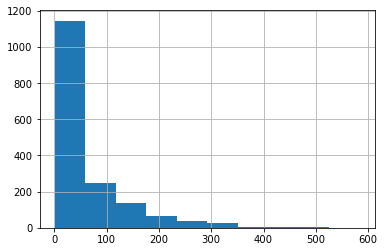

In [29]:
# Visualize the movie counts as a histogram
ratings.groupby('movie_id')['rating'].count().hist()

In [30]:
# Aggregate by user_id, get stats on number (i.e. size) of ratings per user
ratings.groupby('user_id')['rating'].count().describe()

count    943.000000
mean     106.043478
std      100.928288
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

In [31]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


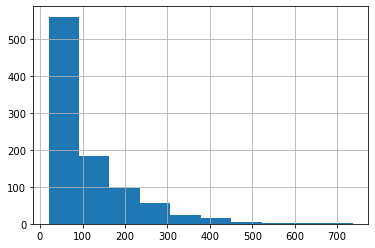

In [32]:
# Visualize the user counts as a histogram
ratings.groupby('user_id')['rating'].count().hist()

Very few movies have been rated and most of the ratings are by a small subset of the users. The above two graphs exhibit the long tail phenomenon

In [33]:
# Which movie has the most ratings?
movies.loc[movies.movie_id==ratings.groupby('movie_id')['rating'].count().idxmax()]

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,Star Wars (1977),01-Jan-1977,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


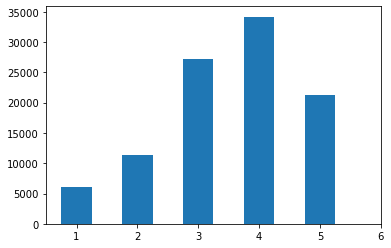

In [34]:
# Are all ratings equally likely? output a bar chart of rating frequency overall
ratings.rating.hist(grid=False,range=(1,6), align='left')

In [35]:
# Of the movies that have 300 or more ratings, what are the top-ten ranked movies?
top_movies = ratings.groupby('movie_id').agg({'user_id':np.size, 'rating':np.mean}).reset_index()
top_movies = top_movies.rename(columns={'user_id': 'size', 'rating': 'rating mean'})
top_movies = top_movies[top_movies['size'] >= 300]
top_movies = pd.merge(movies[['movie_id', 'movie_title']], top_movies).sort_values('rating mean', ascending=False)
top_movies = top_movies.set_index('movie_id')
top_movies.head(10)

,movie_title,size,rating mean
movie_id,,,
50,Star Wars (1977),583,4.358491
98,"Silence of the Lambs, The (1991)",390,4.289744
127,"Godfather, The (1972)",413,4.283293
174,Raiders of the Lost Ark (1981),420,4.252381
313,Titanic (1997),350,4.245714
172,"Empire Strikes Back, The (1980)",367,4.204360
173,"Princess Bride, The (1987)",324,4.172840
100,Fargo (1996),508,4.155512
168,Monty Python and the Holy Grail (1974),316,4.066456


# B. Extract Utility Matrix

In [36]:
def user_id_to_index(id):
    return id-1

def user_index_to_id(idx):
    return idx+1

# Accounts for the bad movie
def movie_id_to_index(id):
    return id-1 if id<bad_row_id else id-2

# Accounts for the bad movie
def movie_index_to_id(idx):
    return idx+1 if idx<(bad_row_id-1) else idx+2

In [37]:
num_users = ratings.user_id.unique().shape[0]
num_movies = ratings.movie_id.unique().shape[0]

utility = np.zeros((num_users, num_movies))

for idx,rating in ratings.iterrows():
    utility[user_id_to_index(rating.user_id), movie_id_to_index(rating.movie_id)] = rating.rating

# should match above!
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 6.31%


# C. Evaluation via Mean Squared Error (MSE)

In [38]:
a = [1, 2, 3, 4, 5]
b = [1, 1, 4, 2, 10]
print("{:.4f}".format(mse(a, b)))

6.2000


In [39]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

u1 = np.array([[2, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 2]])
u2 = np.array([[3, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 7]])

print("{:.4f}".format(mse_utility(u1, u2)))

2.0000


# D. Similarity via Cosine Distance

In [40]:
# Implementing only using primitive Python loops/operations
# sim = (A . B) / ( ||A|| ||B|| )
def cosine_sim(v1, v2):
    
    def l2(v):
        return sum(n**2 for n in v)**(0.5)
    
    numerator = sum(n1*n2 for n1, n2 in zip(v1, v2))
    denominator = l2(v1) * l2(v2)
    return numerator / denominator
    
v1 = [5, 0, 3, 0, 2, 0, 0, 2, 0, 0]
v2 = [3, 0, 2, 0, 1, 1, 0, 1, 0, 1]

print("Cosine Similarity: {:.6f}, expected={:.6f}".format(cosine_sim(v1, v2), cosine_similarity(np.array(v1).reshape(1, -1), np.array(v2).reshape(1, -1))[0][0]))

Cosine Similarity: 0.935601, expected=0.935601


In [41]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

print(sim_matrix(u1))
print(cosine_sim(u1[0], u1[1]))
print(cosine_sim(u1[0], u1[2]))
print(cosine_sim(u1[1], u1[2]))

[[1.         0.58760596 0.49518757]
 [0.58760596 1.         0.94352977]
 [0.49518757 0.94352977 1.        ]]
0.587605960347241
0.49518756847213835
0.9435297685685436


In [42]:
def sim_allpairs(u):
    n = u.shape[0]
    sim = np.eye(n)
    for x in itertools.combinations(range(n), 2):
        s = cosine_sim(u[x[0]], u[x[1]])
        sim[x[0], x[1]] = s
        sim[x[1], x[0]] = s
    
    return sim

print("MSE for U1: {:.4f}".format(mse_utility(sim_matrix(u1), sim_allpairs(u1))))
print("MSE for U2: {:.4f}".format(mse_utility(sim_matrix(u2), sim_allpairs(u2))))

MSE for U1: 0.0000
MSE for U2: 0.0000


In [43]:
%timeit -n 10 -r 3 sim_matrix(utility[:50,:])

The slowest run took 54.03 times longer than the fastest. This could mean that an intermediate result is being cached.
23 ms ± 30.3 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [ ]:
%timeit -n 10 -r 3 sim_allpairs(utility[:50,:])

**1. How does `sim_matrix` work?**

`step1 = u.dot(u.T) + eps`: Computes a symmetric matrix $S$ where $S_{ij} = u_i \cdot u_j$. `eps` is needed to avoid `DivisionByZero` error.

`step2 = np.array([np.sqrt(np.diagonal(step1))])`: `step2` is an array $A$ where $A_i = ||u_i||_2$

`return (step1 / step2 / step2.T)`: Every dot product term in `step1` is divided by the $l_2$ norms of the constituent vectors. Hence element $S_{ij}$ of the final matrix is the cosine distance between vectors $u_i$ and $u_j$.


**2. Why is it `sim_matrix` faster than pairwise calls to `cosine_sim`?**

Vectorized operations are faster and hence calls to `sim_matrix` is preferred.

In [ ]:
def sim_users(u):
    return sim_matrix(u)

# TODO: use sim_matrix to return similarity between items (i.e. movies)
def sim_items(u):
    return sim_matrix(u.T)

print(sim_items(u1))
print(cosine_sim(u1[:, 0], u1[:, 1]))
print(cosine_sim(u1[:, 0], u1[:, 2]))
print(cosine_sim(u1[:, 0], u1[:, 3]))
print(cosine_sim(u1[:, 0], u1[:, 4]))
print(cosine_sim(u1[:, 1], u1[:, 2]))
print(cosine_sim(u1[:, 1], u1[:, 3]))
print(cosine_sim(u1[:, 1], u1[:, 4]))
print(cosine_sim(u1[:, 2], u1[:, 3]))
print(cosine_sim(u1[:, 2], u1[:, 4]))
print(cosine_sim(u1[:, 3], u1[:, 4]))

# E. K-Neighborhood

In [ ]:
# given a slice from a similarity matrix (arr),
# index of "self" (self_idx),
# and k
# return dictionary of k most similar indexes as {idx:sim}
def top_k(arr, self_idx, k):
    ind = arr.argsort()[-k-1:-1]
    return {i:arr[i] for i in sorted(ind)}

In [ ]:
sim_u1 = sim_items(u1)

# Example via u1...
print(sim_u1)
print()

# Top-2 w.r.t. row 0 (should be {1: 0.897, 2:0.937})
print(sim_u1[0])
print(top_k(sim_u1[0], 0, 2))
print()

# Top-2 w.r.t. row 1 (should be {0: 0.897, 2:0.957})
print(sim_u1[1])
print(top_k(sim_u1[1], 1, 2))
print()

# Top-3 w.r.t. col 1 (should be {0: 0.897, 2:0.957, 4:0.667})
print(sim_u1[:, 1])
print(top_k(sim_u1[:, 1], 1, 3))
print()

# F. Recommend via Similar Users

In [ ]:
#       given utility matrix (m_utility),
#       similarity of users (m_sim_users),
#       user index of interest (user_idx),
#       item index of interest (item_idx),
#       neighborhood size (k)
# 
#       output the average of the similarity-weighted ratings
#       of top-k similar users that have
#       rated the item
def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    sim_users = top_k(m_sim_users[user_idx], user_idx, k)
    item_ratings = m_utility.T[item_idx]
    numer = 0
    denom = 0
    for i in sim_users:
        if item_ratings[i] != 0:
            numer += item_ratings[i] * sim_users[i] 
            denom += sim_users[i]
    if denom != 0:
        return numer / denom
    return 0
    
print(u1)
print()
print(sim_users(u1))
print()

# Expected: 5
print(rec_via_users(u1, sim_users(u1), 0, 1, 1))

# Expected: 4.54 ~ (.588 * 5) + (.495 * 4) / (.588 + .495)
print(rec_via_users(u1, sim_users(u1), 0, 1, 2))

## F.1. Evaluation

In [ ]:
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_users(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

In [ ]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 2, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 20, 100)

In [ ]:
plt.plot(ks, mses)


`recs_via_users` picks a random subset of 100 users from the utility matrix and computes the MSE between the true and predicted ratings for all items, parameterized by the neighborhood size `k`. 

As `k` increases, the MSE betweena actual and predicted ratings reduces.

Using the elbow approach, a neighborhood size of 7 seems to be appropriate.

# G. Recommend via SVD

In [ ]:
random.seed(12345)

#       given a utility matrix and
#       number of singular values to use
# 
#       return a projected matrix
#       based upon a limited number of dimensions
#       U_pred = U S V^T
def svd_projection(m_utility, num_dims):
    U, s, Vt = svds(A=m_utility, k=num_dims)
    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = s[i]
    return U @ S @ Vt

def recs_via_svd(m_utility, num_dims, test_n):
    test = random.sample(range(m_utility.shape[0]), test_n)    
    svd_utility = svd_projection(utility, num_dims)
    
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                p = round(svd_utility[user_idx][item_idx])
                
                if p != 0:
                    pred.append(p)
                else:
                    pred.append(1.0e-9)

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
    
ds = []
mses = []
for i in range(100):
    ds.append(i+1)
    mses.append(recs_via_svd(utility, i+1, 100))
    print("{}/100".format(i+1), mses[-1])

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 10, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 20, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 40, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 80, 100)

In [ ]:
plt.plot(ds, mses)

1. SVD is faster than the neighborhood based approach. This is because the neighborhood-based approach has a runtime of $O(n^2)$
2. The quality of the neighborhood based approach is better. This is reflected in the MSE values displayed above.

# H. Recommend via Similar Items

In [ ]:
def rec_via_items(m_utility, m_sim_items, user_idx, item_idx, k):
    sim_items = top_k(m_sim_items[item_idx], item_idx, k)
    item_ratings = m_utility[user_idx]
    numer = 0
    denom = 0
    for i in sim_items:
        if item_ratings[i] != 0:
            numer += item_ratings[i] * sim_items[i] 
            denom += sim_items[i]
    if denom != 0:
        return numer / denom
    return 0
    
print(u1)
print()
print(sim_items(u1))
print()

# Expected: 0
print(rec_via_items(u1, sim_items(u1), 0, 1, 1))

# Expected: 4.54 ~ (.588 * 5) + (.495 * 4) / (.588 + .495)
print(rec_via_items(u1, sim_items(u1), 0, 1, 2))

In [ ]:
random.seed(12345)

def recs_via_items(m_utility, m_sim_items, k, test_n):
    test = random.sample(range(m_sim_items.shape[0]), test_n)
    true = []
    pred = []
    for item_idx in test:
        for user_idx in range(m_utility.shape[0]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_items(m_utility, m_sim_items, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_items = sim_items(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_items(utility, similarity_items, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

In [ ]:
%timeit -n 10 -r 3 recs_via_items(utility, similarity_users, 2, 100)

In [ ]:
%timeit -n 10 -r 3 recs_via_items(utility, similarity_users, 20, 100)

In [ ]:
plt.plot(ks, mses)